
## Problem Statement

- Write a single model.py file that includes GN/LN/BN and takes an argument to decide which normalization to include
- Write a single notebook file to run all the 3 models above for 20 epochs each
- Create these graphs:
  Graph 1: Test/Validation Loss for all 3 models together
  Graph 2: Test/Validation Accuracy for 3 models together
  graphs must have proper annotation

- Find 10 misclassified images for each of the 3 models, and show them as a 5x2 image matrix in 3 separately annotated images. 

# Import Libraries

In [13]:
# import all the required torch functions
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from enum import Enum


# Include Data Transformations

- We first start with defining our data transformations.
- We need to think what our data is and how can we augment it to represent  represent correctly which it might not see otherwise. 

In [14]:
# Train Phase transformations
train_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                            # Note the difference between (0.1307) and (0.1307,)
                        ])

# Test Phase transformations
test_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])

# Dataset and Creating Train/Test Split

In [15]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Check for GPU availability

In [16]:
SEED = 1

# CUDA? Check for GPU availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# Setup Seed, for reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


# Dataloader Arguments & Test/Train Dataloaders

In [17]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

# The Model

- Let's start with model from where we achieved < 20K params (Earlier assignment S3) 

In [18]:
class NormType(Enum):  
  BATCH_NORM = 1
  LAYER_NORM = 2
  GROUP_NORM = 3

class RegularizerType(Enum):  
  NONE = 1
  L1 = 2
  L2 = 3

class Net(nn.Module):

    def __init__(self, input_shape = (1, 28, 28), norm_type=NormType.BATCH_NORM, dropout_value=0.05):
        super(Net, self).__init__()

        # store the norm type for this instance. Control the code based on it
        self.norm_type = norm_type 
        self.dropout_value = dropout_value
        self.input_shape = input_shape
        self.changed_output_size = int(input_shape[1])
        self.norm_type = norm_type

        # Input Block
        self.changed_output_size -= 2 #based on conv2d params
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            self.normalization_layer(self.norm_type, (8, self.changed_output_size, self.changed_output_size, 2)),
            nn.Dropout(self.dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.changed_output_size -= 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            self.normalization_layer(self.norm_type, (15, self.changed_output_size, self.changed_output_size, 3)),
            nn.Dropout(self.dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.changed_output_size /= 2

        # CONVOLUTION BLOCK 2
        self.changed_output_size -= 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            self.normalization_layer(self.norm_type, (15, self.changed_output_size, self.changed_output_size, 3)),
            nn.Dropout(self.dropout_value)
        ) # output_size = 10

        self.changed_output_size -= 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            self.normalization_layer(self.norm_type, (15, self.changed_output_size, self.changed_output_size, 3)),
            nn.Dropout(self.dropout_value)
        ) # output_size = 8

        self.changed_output_size -= 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            self.normalization_layer(self.norm_type, (15, self.changed_output_size, self.changed_output_size, 3)),
            nn.Dropout(self.dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
              
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

        self.dropout = nn.Dropout(self.dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)          
        x = self.convblock7(x)            

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

    def normalization_layer(self, norm_type, dimensions):
      # dimensions => C, H, W, N  (channel, height, width, Group_size for layer norm)

      if NormType.BATCH_NORM == norm_type:
        return nn.BatchNorm2d( dimensions[0] )
      elif NormType.LAYER_NORM == norm_type:
        dimension = [int(dimensions[0]), int(dimensions[1]), int(dimensions[2])]
        return nn.LayerNorm( dimension, elementwise_affine=False ) # requires C, H, W
      elif NormType.GROUP_NORM == norm_type:
        # consider the group size in last parameter. 
        # note: Channels % group_size should be == 0
        return nn.GroupNorm( dimensions[3], dimensions[0] ) # requires group_number, channels(C)
      else:
        # default Batch Norm
        return nn.BatchNorm2d( dimensions[0] )


# Check GPU Availability

In [19]:
# Once we have GPU ready to access, the next step is getting PyTorch to use for storing data (tensors) and computing on data (performing operations on tensors).
# test if PyTorch has access to a GPU
use_cuda = torch.cuda.is_available()

# if GPU is availble use it, if not use CPU. allocate device and assign n/w to it
device = torch.device("cuda" if use_cuda else "cpu")

# Model Summaries

In [20]:
!pip install torchsummary
from torchsummary import summary

# Check all model Summaries
norm_options = [NormType.BATCH_NORM, NormType.LAYER_NORM, NormType.GROUP_NORM]

for norm in norm_options:
  
  print(f"\nModel Summary with NormalizationType => { norm }\n")
  
  # Create model instance with required params
  model = Net(norm_type=norm).to(device)

  # Check model summary
  summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Model Summary with NormalizationType => NormType.BATCH_NORM

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,080
              ReLU-6           [-1, 15, 24, 24]               0
       BatchNorm2d-7           [-1, 15, 24, 24]              30
           Dropout-8           [-1, 15, 24, 24]               0
            Conv2d-9           [-1, 15, 24, 24]             225
        MaxPool2d-10           [-1, 15, 12, 12]               0
           Conv2d-11           [-1, 15, 10, 10]           2,025
      

# Training and Testing

- Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 
- Let's write train and test functions

In [21]:
# define train & test APIs

# Tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, regularizer_lambda=0.01, regularizer_type=RegularizerType.NONE):
  
  model.train() # set the model with training mode (this is the default mode)

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init. 
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict. 
    y_pred = model(data)

    # Calculate model prediction loss
    loss = F.nll_loss(y_pred, target)

    # Handle for L1 loss
    if RegularizerType.L1 == regularizer_type:
      l1 = 0
      for p in model.parameters():
        # absolute sum of all weights
        l1 += torch.norm(p)
      
      # Total loss is sum of model prediction loss + L1 loss
      loss += (regularizer_lambda * l1)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return 100*correct/processed

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return 100. * correct / len(test_loader.dataset)


In [22]:
# Invoke train & evaluate the model 

from torch.optim.lr_scheduler import StepLR

def train_test_model(model, epochs=20):

  # create an optimizer (SGD) with required parameters, 
  # model.parameters() - these are the model parameters to optimize, 
  # learning-rate lr=0.01 and momentum-0.9
  optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

  # Configure epochs to train for
  EPOCHS = epochs

  prev_train_acc = -1
  prev_test_acc = -1
  train_accuracy = 0
  test_accuracy = 0

  # run single epoch as of now.
  for epoch in range(EPOCHS):
      print(f'Epoch: {epoch+1}')

      # train the model loaded on the device with the required optimizer
      train_accuracy = train(model, device, train_loader, optimizer, epoch)

      # set to the next lr params
      scheduler.step()

      # we need to evaluate on test data
      test_accuracy = test(model, device, test_loader)


      # check difference from previous accuracies for better understanding
      if -1 == prev_train_acc:
        prev_train_acc = train_accuracy
      if -1 == prev_test_acc:
        prev_test_acc = test_accuracy

      print(f'train_acc_diff: {train_accuracy - prev_train_acc:.3f} test_acc_diff: {test_accuracy - prev_test_acc:.3f} test_train_diff: {test_accuracy - train_accuracy:.3f}\n')
      prev_train_acc = train_accuracy
      prev_test_acc = test_accuracy

  # update model metric
  model_metric = [train_losses, test_losses, train_acc, test_acc]
  return model_metric

In [23]:
import copy

# Check all model Summaries
norm_options = [NormType.BATCH_NORM, NormType.LAYER_NORM, NormType.GROUP_NORM]
norm_name = ["BATCH_NORM", "LAYER_NORM", "GROUP_NORM"]

# evaluation metrics for different models
evaluation_metrics = {}
model_metric = []

print(f"\nTrain & Evaluate different model\n")

for ndx, norm in enumerate(norm_options):
  
  print(f"\nTrain & Test Model with NormalizationType => { norm }\n")
  
  # Create model instance with required params
  model = Net(norm_type=norm).to(device)

  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  model_metric = train_test_model(model, epochs=5)

  evaluation_metrics[norm_name[ndx]] = model_metric


Train & Evaluate different model


Train & Test Model with NormalizationType => NormType.BATCH_NORM

Epoch: 1


Loss=0.08454345911741257 Batch_id=468 Accuracy=92.29: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]



Test set: Average loss: 0.0896, Accuracy: 9703/10000 (97.03%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 4.738

Epoch: 2


Loss=0.018272867426276207 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]



Test set: Average loss: 0.0478, Accuracy: 9836/10000 (98.36%)

train_acc_diff: 5.505 test_acc_diff: 1.330 test_train_diff: 0.563

Epoch: 3


Loss=0.052602723240852356 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]



Test set: Average loss: 0.0366, Accuracy: 9888/10000 (98.88%)

train_acc_diff: 0.413 test_acc_diff: 0.520 test_train_diff: 0.670

Epoch: 4


Loss=0.15689818561077118 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]



Test set: Average loss: 0.0416, Accuracy: 9859/10000 (98.59%)

train_acc_diff: 0.218 test_acc_diff: -0.290 test_train_diff: 0.162

Epoch: 5


Loss=0.059279054403305054 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]



Test set: Average loss: 0.0326, Accuracy: 9893/10000 (98.93%)

train_acc_diff: 0.145 test_acc_diff: 0.340 test_train_diff: 0.357


Train & Test Model with NormalizationType => NormType.LAYER_NORM

Epoch: 1


Loss=0.08852225542068481 Batch_id=468 Accuracy=89.09: 100%|██████████| 469/469 [00:16<00:00, 27.67it/s]



Test set: Average loss: 0.0886, Accuracy: 9763/10000 (97.63%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 8.538

Epoch: 2


Loss=0.037077147513628006 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:18<00:00, 25.99it/s]



Test set: Average loss: 0.0470, Accuracy: 9876/10000 (98.76%)

train_acc_diff: 8.297 test_acc_diff: 1.130 test_train_diff: 1.372

Epoch: 3


Loss=0.059974029660224915 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0387, Accuracy: 9893/10000 (98.93%)

train_acc_diff: 0.472 test_acc_diff: 0.170 test_train_diff: 1.070

Epoch: 4


Loss=0.11643878370523453 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]



Test set: Average loss: 0.0438, Accuracy: 9865/10000 (98.65%)

train_acc_diff: 0.337 test_acc_diff: -0.280 test_train_diff: 0.453

Epoch: 5


Loss=0.03827355429530144 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]



Test set: Average loss: 0.0351, Accuracy: 9894/10000 (98.94%)

train_acc_diff: 0.143 test_acc_diff: 0.290 test_train_diff: 0.600


Train & Test Model with NormalizationType => NormType.GROUP_NORM

Epoch: 1


Loss=0.05676254630088806 Batch_id=468 Accuracy=89.32: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]



Test set: Average loss: 0.0582, Accuracy: 9828/10000 (98.28%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 8.958

Epoch: 2


Loss=0.16071940958499908 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]



Test set: Average loss: 0.0544, Accuracy: 9821/10000 (98.21%)

train_acc_diff: 7.918 test_acc_diff: -0.070 test_train_diff: 0.970

Epoch: 3


Loss=0.010130700655281544 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s]



Test set: Average loss: 0.0383, Accuracy: 9879/10000 (98.79%)

train_acc_diff: 0.783 test_acc_diff: 0.580 test_train_diff: 0.767

Epoch: 4


Loss=0.03040638379752636 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]



Test set: Average loss: 0.0346, Accuracy: 9880/10000 (98.80%)

train_acc_diff: 0.077 test_acc_diff: 0.010 test_train_diff: 0.700

Epoch: 5


Loss=0.06745727360248566 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]



Test set: Average loss: 0.0337, Accuracy: 9890/10000 (98.90%)

train_acc_diff: 0.210 test_acc_diff: 0.100 test_train_diff: 0.590



# Plot the model's learning progress

- Plot training and test accuracies of all models

<ipython-input-24-d4840e90c6c3>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2, 1)
<ipython-input-24-d4840e90c6c3>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


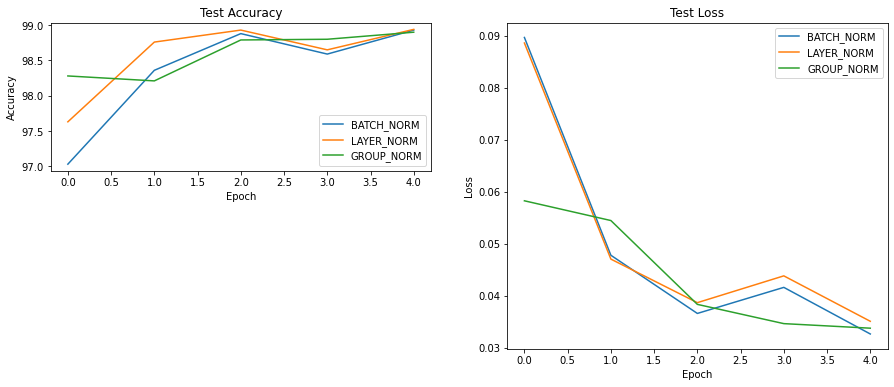

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

for name in norm_name:
  
  train_losses  = evaluation_metrics[name][0]
  test_losses   = evaluation_metrics[name][1]
  train_acc     = evaluation_metrics[name][2]
  test_acc      = evaluation_metrics[name][3]

  plt.subplot(2,2, 1)

  plt.plot(test_acc)
  plt.legend(norm_name)
  plt.title("Test Accuracy")

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(test_losses)
  plt.legend(norm_name)
  plt.title('Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


# Move tesnors to numpy as required

- train_losses is a list, but train_losses[i] is a tensor
- all others are numpy

## APIs to use

- To go from np.array to cpu Tensor    => torch.from_numpy().
- To go from cpu Tensor to gpu Tensor  => .cuda()
- To go from a Tensor that requires_grad to one that does not => .detach() 
- To go from a gpu Tensor to cpu Tensor => .cpu()
- To gp from a cpu Tensor to np.array   => .numpy()